# Deep Learning model for Fashion item recognition

* Classification of Fashion-MNIST dataset with tensorflow.keras, using a Convolutional Neural Network (CNN) architecture.

* The dataset contains 70,000 grayscale images in 10 categories.
Label Description:

``
0 T-shirt/top 
1 Trouser 
2 Pullover 
3 Dress 
4 Coat 
5 Sandal 
6 Shirt 
7 Sneaker 
8 Bag 
9 Ankle boot``

* The images show individual articles of clothing at low resolution (28 by 28 pixels).

### Imports

In [0]:

from keras import backend as K # Importing Keras backend (by default it is Tensorflow)
from keras.datasets import fashion_mnist # Import the mnist dataset
from keras.layers import Input, Conv2D, Dense, Dropout, Flatten, MaxPool2D,BatchNormalization # Layers to be used for building our model
from keras.models import Model # The class used to create a model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import np_utils # Utilities to manipulate numpy arrays
from tensorflow import set_random_seed # Used for reproducible experiments
from sklearn.metrics import confusion_matrix,classification_report
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator # for data augmentetion

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

import gc
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

* 60,000 images to train the network and 10,000 images to test it.
* The shape of each image is 28x28 pixels x1 channel (grey).
* **Data Normalization**: The values of the inputs are in [0, 255] so we normalize them to [0, 1] dividing by 255.

In [0]:
batch_size = 128
classes = 10
epochs = 60

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# Reshape data for Conv2D
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
input_shape = (28, 28, 1)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
# Data Normalization
X_train /= 255
X_test /= 255
Y_train = np_utils.to_categorical(y_train, classes)
Y_test = np_utils.to_categorical(y_test, classes)

In [0]:
# function to plot results
def plot_history(hs, epochs, metric):
    plt.clf()
    plt.rcParams['figure.figsize'] = [10, 5]
    plt.rcParams['font.size'] = 16
    for label in hs:
        plt.plot(hs[label].history[metric], label='{0:s} train {1:s}'.format(label, metric))
        plt.plot(hs[label].history['val_{0:s}'.format(metric)], label='{0:s} validation {1:s}'.format(label, metric))
    x_ticks = np.arange(0, epochs + 1, epochs / 10)
    x_ticks [0] += 1
    plt.xticks(x_ticks)
    plt.ylim((0, 1))
    plt.xlabel('Epochs')
    plt.ylabel('Loss' if metric=='loss' else 'Accuracy')
    plt.legend()
    plt.show()

In [0]:
def clean_up(model):
    K.clear_session()
    del model
    gc.collect()

### Data augmentetion

Data augmentation is often used in order to improve generalisation properties. Typically, horizontal ﬂipping,zooming shifts are used. However, in this case data augmentation did not improved the classifier's results. Bellow are the the  data augmentation settings that tried out.

In [58]:
image_generator = ImageDataGenerator(
      rotation_range=10,
      zoom_range = 0.1, 
      width_shift_range=0.05,
      height_shift_range=0.05,
      horizontal_flip=False,
      vertical_flip=False, 
      data_format="channels_last",
      zca_whitening=True
  )
# fit data for zca whitening
image_generator.fit(X_train, augment=True)

augment_size=5000
# get transformed images
randidx = np.random.randint(X_train.shape[0], size=augment_size)
x_augmented = X_train[randidx].copy()
y_augmented = Y_train[randidx].copy()
x_augmented = image_generator.flow(x_augmented, np.zeros(augment_size),
                                     batch_size=augment_size, shuffle=False).next()[0]
# append augmented data to trainset
X_train2 = np.concatenate((X_train, x_augmented))
Y_train2 = np.concatenate((Y_train, y_augmented))

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:334: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


### The Model 

- We use a Functional Model with following layers:
    
- `Input` layer 
- ` 2D Convolution layer` with 16 filters and [5x5] kernel size.
    - `Batch Normalization`
    - `Max Pooling`
    - `Dropout` 25%
- ` 2D Convolution layer` with 32 filters and [5x5] kernel size.
    - `Batch Normalization`
    - `Max Pooling`
    - `Dropout` 25%
- Then, `Flatten` the convolved images so as to input them to a Dense Layer.
- `Dense Layer` hidden layer with output 1024 nodes.
    - `Dropout` 25%
- `Output Layer`.

To compile the model:
- As optimazer we use `Adam`.
- As loss function we use `categorical_crossentropy` because the targets are categorical one-hot encoded.

To evaluate the model:
- Accuracy on both validation and test set is used.


**In order to find the above model the following strategy is used:**
1. As mentioned above, data augmentetion worsen the classifier's performance; thus, only the original data is used. In case of less data, data augmentetion would be useful.
2. I choose to build a model with `CNNs` because they outerperform the other NN at image classification tasks. Additionally, I built a MLP model with 2 hidden layers, which had 3% less accuracy compared to the CNN model.
    
    - The proper number of CNN layers is defined to two after several trials. In fact, more layers cause overfitting.
    
    - At detector stage of convolutional layers `ReLU` is used as activiation function. Other activiation functions such as ELU was also used but with no better results than Relu.
   
    - At polling stage of convolutional layers `max pooling` was choosen with striding [2,2]. Without striding the model had slightly better accuracy, but way more parameters need to be trained. 
   
    - Each convolution layer has different number of `filters`. In this way, the network will learn more details about the unique characteristics of each class. These, values was defined after trials.
    
    - The `kernel size` was set to [5,5] .
    
    - The `dilation rate` found to not improve model's accuracy. Thus, it was set to [1,1].
    
    - `Striding` was set to [1,1], since the input size of images is already small we do not want to loose any information.
    
    - `Dropout` was set to [0.25], helping the model to avoid overfitting and train faster.
    
    - `Batch normalization` between convolution(linear) and detector stage(non-linear) acts as regularizer, allowing higher learning rates. In this case, Batch normalization helped the model to be trained in fewer epochs and the model had slightly better accuracy. Thus, we used this normalization strategy.
    - `Kernel regularization` was tested without better results on model's accuracy.

3. After the convolutional layers an `MLP` with one hidden layer is used to do the classification job, as MLPs are powerful classifiers.
      
     - `ReLU` used as activiation function.
     - `Dropout` [0.25] was used again at this stage.

4.  As output activiation function we use `softmax`, which is the suggested output activiation function for multi-label classification problems.
5. `EarlyStopping` is used in order to find the proper number of epochs which reduces the generalization error.



In [0]:
def train_model(
        optimizer,
        epochs=100,
        batch_size=128,
        conv_layers=2,
        conv_activation='relu',
        hidden_layers=1,
        hidden_activation='relu',
        batch_normalization = False,
        conv_dropout=False,
        output_activation='softmax'):
    
    np.random.seed(1402) # Define the seed for numpy to have reproducible experiments.
    set_random_seed(1981) # Define the seed for Tensorflow to have reproducible experiments.
    model_name = 'gru-{0:d}-{1:d}'.format(conv_layers, epochs)
    
    # Define the input layer.
    input = Input(
        shape=input_shape,
        name='Input'
    )

    x = input
    
    
    # Define the convolutional layers.
    for i in range(conv_layers):
        x = Conv2D(
            filters=16*(i+1),
            kernel_size=(5, 5),
            strides=(1, 1),
            padding='same',
            dilation_rate=(1, 1),
            activation=conv_activation,
            #kernel_regularizer=regularizers.l2(0.01),
            name='Conv2D-{0:d}'.format(i + 1)
        )(x)
    
  
        
        if batch_normalization:
            x = BatchNormalization(axis=2,name='Batch_Normalization-{0:d}'.format(i + 1)
                                )(x)
        
        x = MaxPool2D(
            pool_size=(2, 2),
            strides=(2, 2),
            padding='same',
            name='MaxPool2D-{0:d}'.format(i + 1)
        )(x)
        
        if conv_dropout:
            x = Dropout(
                rate=0.25,
                name='Dropout-{0:d}'.format(i + 1)
            )(x)

    
    # Flatten the convolved images so as to input them to a Dense Layer
    x = Flatten(name='Flatten')(x)
    
  
    # Define the remaining hidden layers.
    for i in range(hidden_layers):
        x = Dense(
            units=256,
            kernel_initializer='glorot_uniform',
            activation=hidden_activation,
            name='Hidden-{0:d}'.format(i + 1)
        )(x)
        
    if conv_dropout:
            x = Dropout(
                rate=0.25,
                name='Dropout-{0:d}'.format(3)
            )(x)
        
    # Define the output layer.
    output = Dense(
        units=classes,
        activation=output_activation,
        name='Output'
    )(x)

    # Define the model and train it.
    model = Model(inputs=input, outputs=output)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    hs = model.fit(
        x=X_train,
        y=Y_train,
        validation_split=0.1, # use 10% of the training data as validation data
        epochs=epochs,
        verbose=0,
        batch_size=batch_size,
        callbacks=[EarlyStopping(monitor='val_acc', patience=5, verbose=1),
                   ModelCheckpoint(filepath='{0:s}.chk'.format(model_name),
                                   monitor='val_acc',
                                   save_best_only=True,
                                   save_weights_only=True
                                  )
                  ]
    )
    print('Finished training.')
    print('------------------')
    model.summary() # Print a description of the model.
    return model, hs

### Training and Evaluation

In [102]:
# Using Adam
optimizer = Adam()

# 2 Convolutional Layers and 1 dense Layer
model, hs = train_model(
    optimizer=optimizer,
    epochs=50,
    batch_size=batch_size,
    conv_layers=2, 
    conv_activation='relu',
    batch_normalization=True,
    conv_dropout=True,
    hidden_layers=1,
    output_activation='softmax'
)

# Evaluate on test data and show all the results.
eval_model = model.evaluate(X_test, Y_test, verbose=1)
# Predictions on test set
predictions = model.predict(X_test)

clean_up(model=model)

Epoch 00028: early stopping
Finished training.
------------------
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 28, 28, 1)         0         
_________________________________________________________________
Conv2D-1 (Conv2D)            (None, 28, 28, 16)        416       
_________________________________________________________________
Batch_Normalization-1 (Batch (None, 28, 28, 16)        112       
_________________________________________________________________
MaxPool2D-1 (MaxPooling2D)   (None, 14, 14, 16)        0         
_________________________________________________________________
Dropout-1 (Dropout)          (None, 14, 14, 16)        0         
_________________________________________________________________
Conv2D-2 (Conv2D)            (None, 14, 14, 32)        12832     
_________________________________________________________________
Batch_Norm

Train Loss     : 0.12679
Validation Loss: 0.22890
Test Loss      : 0.25530
---
Train Accuracy     : 0.95113
Validation Accuracy: 0.92467
Test Accuracy      : 0.92580


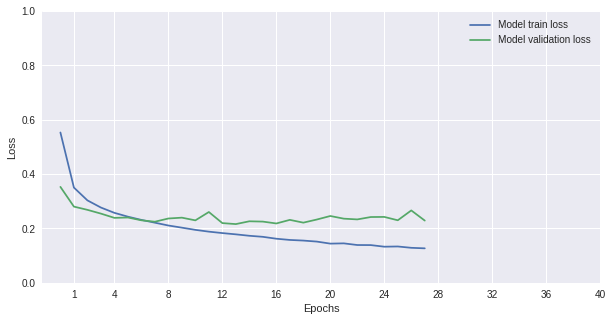

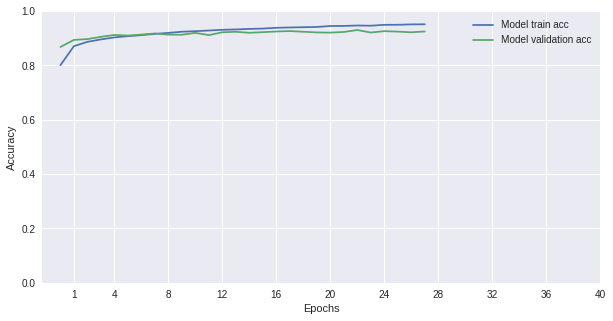

In [103]:
print("Train Loss     : {0:.5f}".format(hs.history['loss'][-1]))
print("Validation Loss: {0:.5f}".format(hs.history['val_loss'][-1]))
print("Test Loss      : {0:.5f}".format(eval_model[0]))
print("---")
print("Train Accuracy     : {0:.5f}".format(hs.history['acc'][-1]))
print("Validation Accuracy: {0:.5f}".format(hs.history['val_acc'][-1]))
print("Test Accuracy      : {0:.5f}".format(eval_model[1]))


# Plot train and validation error per epoch.
plot_history(hs={'Model': hs}, epochs=40, metric='loss')
plot_history(hs={'Model': hs}, epochs=40, metric='acc')

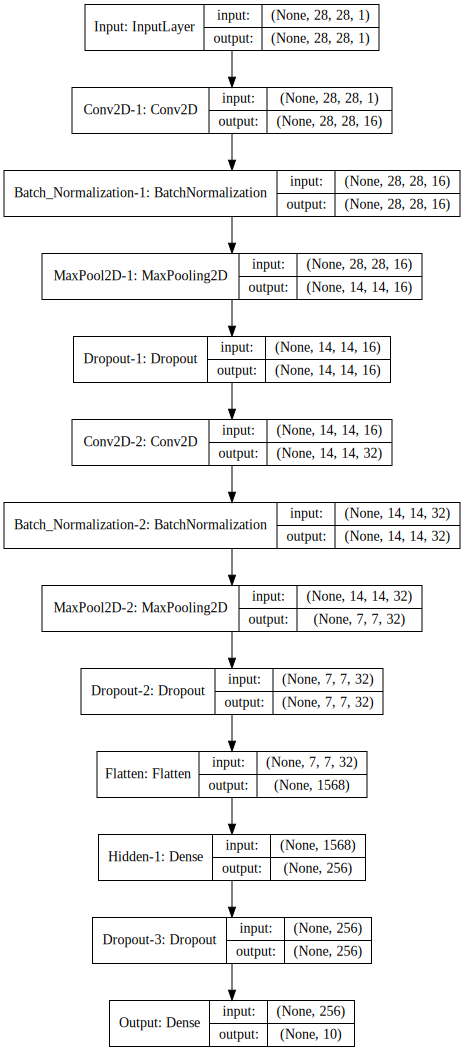

In [104]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [105]:
predicted_labels = np.apply_along_axis(np.argmax, 1, predictions)
#print('Predicted labels:', predicted_labels)
misclassified = y_test != predicted_labels
#print('Misclassified:', misclassified)
misclassified_indices = np.argwhere(misclassified)
#print('Misclassified indices:\n', misclassified_indices)
print('Number of misclassified:', len(misclassified_indices))

Number of misclassified: 742


### Model's performance

- This relatively small and easy to be trained CNN model achieved 92.58% accuracy and 25.53% loss on test set (742 out of 10000 images was misclassified). Furthermore, 417,650 parameters was trained in 28 epochs, where the model retains its generalization power.

### Misclassified images

In [0]:
def plot_image(i, predictions, true_labels, img):
    predictions_array, true_label, img = predictions[i], true_labels[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    plt.imshow(img.reshape(28,28), cmap=plt.cm.binary)
    
    predicted_label = np.argmax(predictions_array)
    
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'
  
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                         100*np.max(predictions_array),
                                         class_names[true_label]),
                                         color=color)
    
def plot_value_array(i, predictions, true_labels, show_xticks=False):
    predictions_array, true_label = predictions[i], true_labels[i]
    plt.grid(False)
    plt.xticks([])
    if show_xticks:
        plt.xticks(range(10), class_names, rotation='vertical')
    else:
        plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1]) 
    predicted_label = np.argmax(predictions_array)
 
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('green')

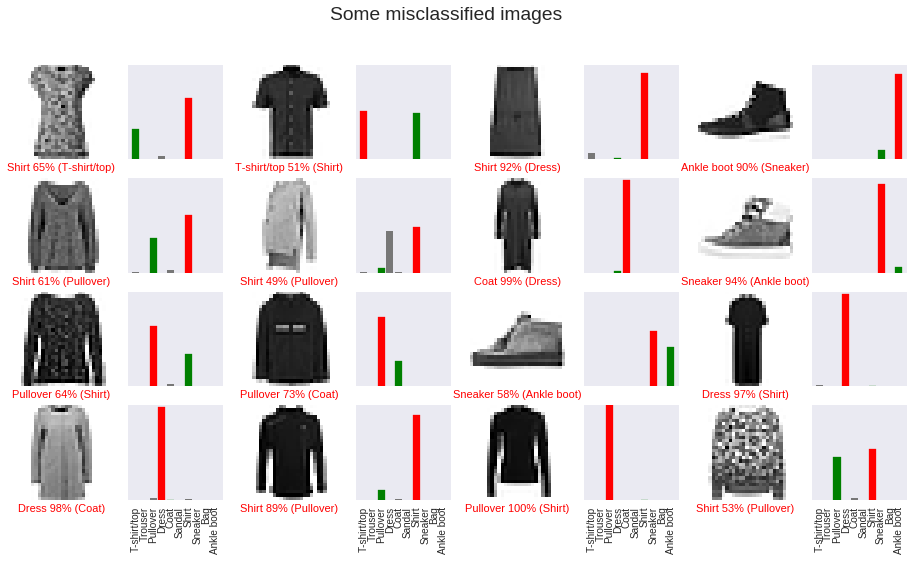

In [107]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

num_rows = 4
num_cols = 4
num_images = num_rows * num_cols

plt.figure(figsize=(2*2*num_cols, 2*num_rows))
show_x_ticks = False
plt.title('Some misclassified images')

for i in range(num_images):
    if i >= num_images - num_cols:
        show_x_ticks = True
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(misclassified_indices[i-1][0], predictions, y_test, X_test)
    plt.subplot(num_rows, 2 * num_cols, 2*i+2)
    plot_value_array(misclassified_indices[i-1][0], predictions, y_test, show_x_ticks)

plt.suptitle('Some misclassified images')
plt.show;

- As it can been seen from the above plots, even a human eye cannot easily discriminate the proper class for each of those images. Thus, this model is performing quite well at fashion recognition.

In [108]:
print(confusion_matrix(y_test,predicted_labels))
print(classification_report(y_test,predicted_labels,target_names=class_names))

[[850   0  19  15   2   1 106   0   7   0]
 [  1 990   0   7   1   0   0   0   1   0]
 [ 15   1 885   6  45   0  48   0   0   0]
 [ 11   4  10 932  22   0  20   0   1   0]
 [  0   1  44  16 889   0  50   0   0   0]
 [  0   0   0   0   0 983   0  10   0   7]
 [ 75   2  50  26  46   0 799   0   2   0]
 [  0   0   0   0   0   5   0 979   0  16]
 [  3   2   0   5   3   0   1   3 981   2]
 [  0   0   0   0   0   3   1  26   0 970]]
              precision    recall  f1-score   support

 T-shirt/top       0.89      0.85      0.87      1000
     Trouser       0.99      0.99      0.99      1000
    Pullover       0.88      0.89      0.88      1000
       Dress       0.93      0.93      0.93      1000
        Coat       0.88      0.89      0.89      1000
      Sandal       0.99      0.98      0.99      1000
       Shirt       0.78      0.80      0.79      1000
     Sneaker       0.96      0.98      0.97      1000
         Bag       0.99      0.98      0.98      1000
  Ankle boot       0.97     

- Finally, the confusion matrix shows that the model classified 'trouser', 'sandal','sneaker', 'bag' and 'ankle boot' classes over 97% correctly but seemed to struggle quite a bit with 'shirt' class (79% accurate), which was regularly confused with 't-shirt/top', 'pullover' and 'coat' classes.